## Convolutional Neural Networks
- CS231n Convolutional Neural Networks for Visual Recognition: https://git.io/vKlww
- http://pythonkim.tistory.com/56

In [25]:
import tensorflow as tf
import math
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
%matplotlib inline

1.0.1


In [26]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [27]:
x = tf.placeholder("float", [None, 784])
y = tf.placeholder("float", [None, 10])

- Image reshape to 4D [-1, 28, 28, 1]
  - The MNIST images have just one gray color value (the number of color channels is one), so that the last value is one.

In [28]:
x_image = tf.reshape(x, [-1, 28, 28, 1])
print(x_image.get_shape())

(?, 28, 28, 1)


In [29]:
keep_prob = tf.placeholder(tf.float32)

- **stride**
  - we must specify the stride with which we slide the filter. 
  - stride = 1: we slide the filters one pixel at a time. 
  - stride = 2: we slide the filters two pixel at a time. 
  - This will produce smaller output volumes spatially.
- **padding**
  - we need pad the input volume with zeros around the border. 
  - zero padding

- The CONV layer’s parameters consist of a set of learnable filters.
- The convolution will compute 32 kernels (features) for each 5x5 patch. 
- Its weight tensor will have a shape of [5, 5, 1, 32]. 
  - The first two dimensions are the kernel size
  - The third is the number of input channels (here, it is one channel)
  - The last one is the number of kernels (features). 
- A bias vector has a component per kernel.

- https://www.tensorflow.org/api_docs/python/nn/convolution#conv2d
- https://www.tensorflow.org/api_docs/python/nn/pooling#max_pool

- If padding == "SAME": output_spatial_shape[i] = ceil(input_spatial_shape[i] / strides[i])

In [30]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 8], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[8]))
h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
d_h_pool1 = tf.nn.dropout(h_pool1, keep_prob=keep_prob)
print(h_conv1)
print(h_pool1)
print(d_h_pool1)

Tensor("Relu_3:0", shape=(?, 28, 28, 8), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 14, 14, 8), dtype=float32)


In [32]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 8, 8], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[8]))
h_conv2 = tf.nn.relu(tf.nn.conv2d(d_h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
d_h_pool2 = tf.nn.dropout(h_pool2, keep_prob=keep_prob)
print(h_conv2)
print(h_pool2)
print(d_h_pool2)

Tensor("Relu_4:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("MaxPool_3:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 7, 7, 8), dtype=float32)


In [34]:
h_pool2_flat = tf.reshape(d_h_pool2, [-1, 7 * 7 * 8])

In [41]:
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 8, 256], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[256]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
d_h_fc1 = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

In [42]:
W_fc2 = tf.Variable(tf.truncated_normal([256, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
pred = tf.matmul(d_h_fc1, W_fc2) + b_fc2

In [43]:
error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(error)

In [50]:
# Initializing the variables
init = tf.global_variables_initializer()

# Parameters
training_epochs = 100
learning_rate = 0.001
batch_size = 100

# Calculate accuracy with a Test model 
prediction_ground_truth = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction_ground_truth, tf.float32))

In [51]:
def printLossAccuracyForTestData(epoch, sess, test_error_value_list, test_accuracy_list):
    accuracy_value, error_value = sess.run((accuracy, error), 
                                           feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 0.5})
    test_error_value_list.append(error_value)
    test_accuracy_list.append(accuracy_value)
    print("epoch: %d, test_error_value: %f, test_accuracy: %f" % ( epoch, error_value, accuracy_value ))

def drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_error_value_list, test_accuracy_list):
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(epoch_list, train_error_value_list, 'r', label='Train')
    plt.plot(epoch_list, validation_error_value_list, 'g', label='Validation')
    plt.plot(epoch_list, test_error_value_list, 'b', label='Test')
    plt.ylabel('Total Error')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(epoch_list, test_accuracy_list, 'b', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.yticks(np.arange(min(test_accuracy_list), max(test_accuracy_list), 0.05))
    plt.grid(True)
    plt.legend(loc='lower right')            
    plt.show()

def drawFalsePrediction(sess, numPrintImages):
    ground_truth = sess.run(tf.argmax(y, 1), feed_dict={y: mnist.test.labels})
    prediction = sess.run(tf.argmax(pred, 1), feed_dict={x: mnist.test.images, keep_prob: 0.5})

    fig = plt.figure(figsize=(20, 5))
    j = 1
    for i in range(mnist.test.num_examples):
        if (j > numPrintImages):
            break;
        if (prediction[i] != ground_truth[i]):
            print("Error Index: %s, Prediction: %s, Ground Truth: %s" % (i, prediction[i], ground_truth[i]))
            img = np.array(mnist.test.images[i])
            img.shape = (28, 28)
            plt.subplot(1, numPrintImages, j)
            plt.imshow(img)
            j += 1

total batch: 550
epoch: 0, test_error_value: 2.015407, test_accuracy: 0.291000
epoch: 1, test_error_value: 1.242550, test_accuracy: 0.585100
epoch: 2, test_error_value: 0.890830, test_accuracy: 0.708200
epoch: 3, test_error_value: 0.734925, test_accuracy: 0.766400
epoch: 4, test_error_value: 0.622793, test_accuracy: 0.798000
epoch: 5, test_error_value: 0.542529, test_accuracy: 0.823000
epoch: 6, test_error_value: 0.489445, test_accuracy: 0.847500
epoch: 7, test_error_value: 0.433259, test_accuracy: 0.860200
epoch: 8, test_error_value: 0.407578, test_accuracy: 0.868400
epoch: 9, test_error_value: 0.377956, test_accuracy: 0.879900
epoch: 10, test_error_value: 0.357250, test_accuracy: 0.886000
epoch: 11, test_error_value: 0.348965, test_accuracy: 0.884000
epoch: 12, test_error_value: 0.322073, test_accuracy: 0.894400
epoch: 13, test_error_value: 0.307421, test_accuracy: 0.900600
epoch: 14, test_error_value: 0.286957, test_accuracy: 0.909200
epoch: 15, test_error_value: 0.278386, test_accu

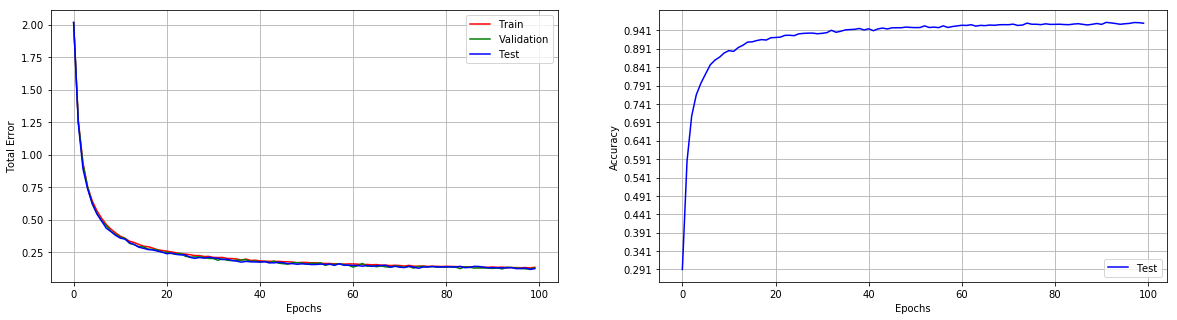

Error Index: 62, Prediction: 5, Ground Truth: 9
Error Index: 66, Prediction: 0, Ground Truth: 6
Error Index: 73, Prediction: 8, Ground Truth: 9
Error Index: 95, Prediction: 8, Ground Truth: 4
Error Index: 119, Prediction: 8, Ground Truth: 2
Error Index: 125, Prediction: 4, Ground Truth: 9
Error Index: 158, Prediction: 2, Ground Truth: 3
Error Index: 160, Prediction: 1, Ground Truth: 4
Error Index: 184, Prediction: 2, Ground Truth: 8
Error Index: 242, Prediction: 0, Ground Truth: 8
Optimization Finished!


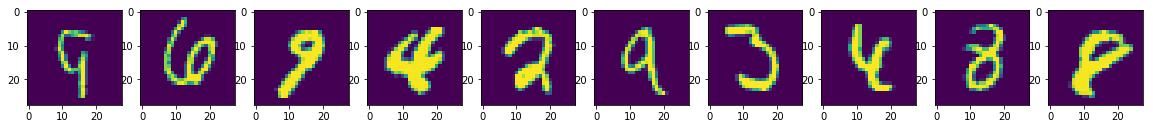

In [52]:
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(math.ceil(mnist.train.num_examples/float(batch_size)))
    
    print("total batch: %d" % total_batch)

    epoch_list                  = []
    train_error_value_list      = []
    validation_error_value_list = []
    test_error_value_list       = []
    test_accuracy_list          = []
            
    # Training cycle
    for epoch in range(training_epochs):

        # Loop over all batches
        for i in range(total_batch):
            batch_images, batch_labels = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={x: batch_images, y: batch_labels, keep_prob: 0.5})
        
        epoch_list.append(epoch)

        # Train Error Value
        t_error_value = sess.run(error, feed_dict={x: mnist.train.images, y: mnist.train.labels, keep_prob: 0.5})
        train_error_value_list.append(t_error_value)

        # Validation Error Value
        v_error_value = sess.run(error, feed_dict={x: mnist.validation.images, y: mnist.validation.labels, keep_prob: 0.5})
        validation_error_value_list.append(v_error_value)

        printLossAccuracyForTestData(epoch, sess, test_error_value_list, test_accuracy_list)

    drawErrorValues(epoch_list, train_error_value_list, validation_error_value_list, test_error_value_list, test_accuracy_list)

    drawFalsePrediction(sess, 10)
            
    print("Optimization Finished!")